In [55]:
import pandas as pd
import numpy as np
import meld
import scanpy as sc
import matplotlib.pyplot as plt
import scprep
import sklearn
np.random.seed(42)

This notebook is used to determine the differential abundance, and thus must be executed on the integrated data. Beforehands, the data must be converted to h5ad as in the script convert.R.

In [56]:
adata = sc.read_h5ad("07_preprocessed_highDiet_normalDiet_scenario.1.h5ad")

# Get the loadings of the different reductions, the metadata and raw data as a dataframe. We will mostly be using the umap to project the data.
umap = adata.obsm["X_umap"]
pca = adata.obsm["X_pca"]
metadata = adata.obs
data = adata.to_df()

del adata

# create the affinity graph and perform the MELD algorithm on it. The beta and knn values come from the paper and were determined optimals after a benchmark by the authors.
meld_op = meld.MELD(beta = 67, knn=7)
sample_densities = meld_op.fit_transform(pca, sample_labels=metadata["orig.ident"])

Building graph on 11760 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 3.80 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 4.12 seconds.


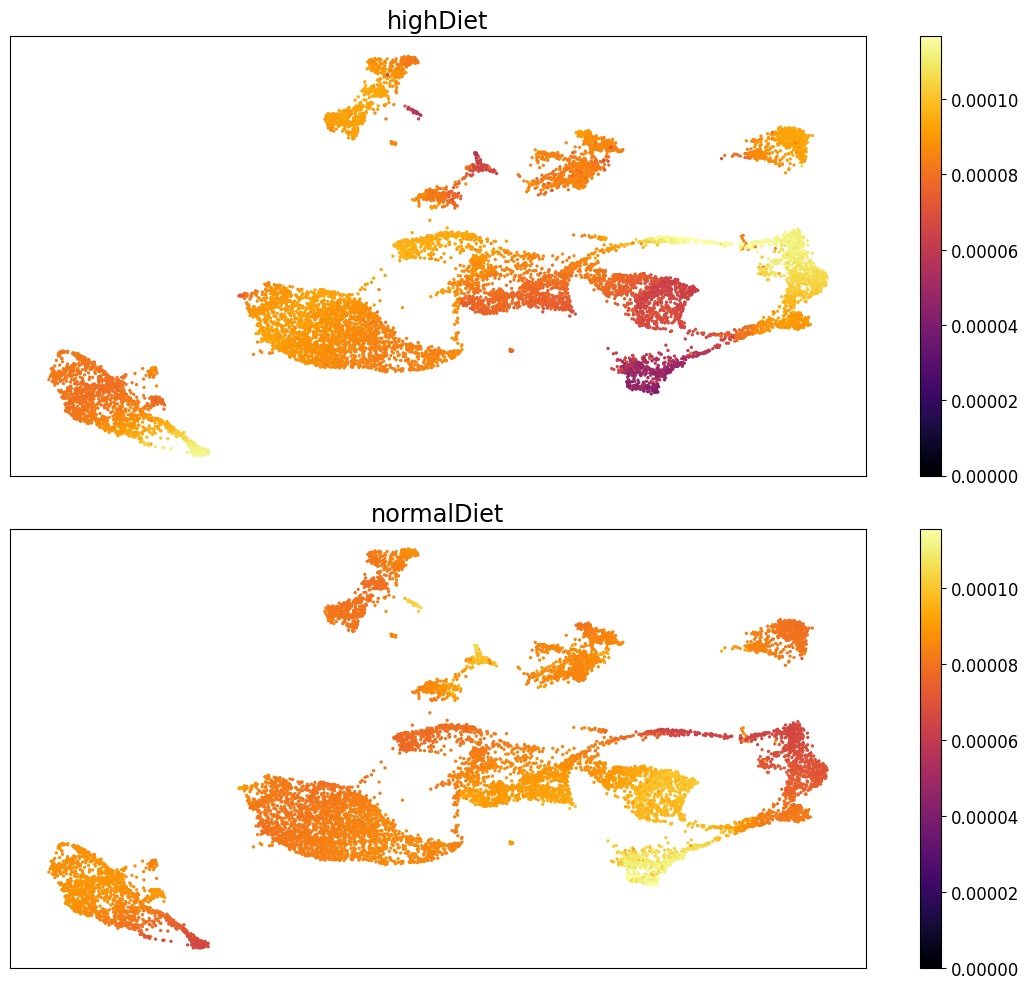

In [57]:
fig, axes = plt.subplots(2,1, figsize=(11,10))

# Display the activity of the cells on the umap (?)
for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(umap, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    

fig.tight_layout()

In [58]:
def replicate_normalize_densities(sample_densities, replicate):
    # Get the unique replicates
    replicates = np.unique(replicate)
    sample_likelihoods = sample_densities.copy()
    for rep in replicates:
        # Select the columns of `sample_densities` for that replicate
        curr_cols = sample_densities.columns[[rep in col for col in sample_densities.columns]]
        # Apply L1 normalization between the same technical replicate of the conditions. If there is no replicate, apply L1 normalization on the conditions
        sample_likelihoods[curr_cols] = sklearn.preprocessing.normalize(sample_densities[curr_cols], norm='l1')

    return sample_likelihoods

# The same technical replicates must have the same name between conditions. If there are no replicates, give a common part present in both conditions.
sample_likelihoods = replicate_normalize_densities(sample_densities, ["Diet"])


/home/benjaminl/miniconda3/envs/scell/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


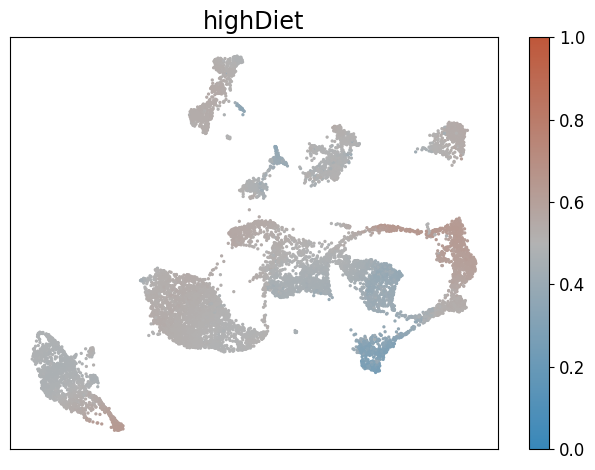

In [59]:
experimental_samples = ["highDiet"] # replicates

# Display the likelihood of cells belonging to the condition of the replicate (higher values mean higher likelihood).
# When there are only two conditions, the values of the second condition are just 1 - values of the first condition,
# which is pointless to represent.
if(len(experimental_samples) > 1):
    fig, ax = plt.subplots(1,len(experimental_samples), figsize=(13,4))

    for curr_sample, ax in zip(experimental_samples, axes):
        scprep.plot.scatter2d(umap, c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                            vmin=0, vmax=1,
                            title=curr_sample, ticks=False, ax=ax)
        fig.tight_layout()
else:
    scprep.plot.scatter2d(umap, c=sample_likelihoods[experimental_samples[0]], cmap=meld.get_meld_cmap(),
                            vmin=0, vmax=1,
                            title=experimental_samples[0], ticks=False)


In [60]:
# Display the mean and std between replicates. Only meaningful with technical replicates in one condition.
# Low standard deviation highlight areas where the cells are similarly enriched or depleted between replicates
if(len(experimental_samples) > 1):
    fig, axes = plt.subplots(1,2, figsize=(8.7,4))

    scprep.plot.scatter2d(umap, c=sample_likelihoods[experimental_samples].mean(axis=1), 
                        cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                        title='Mean', ticks=False, ax=axes[0])
    scprep.plot.scatter2d(umap, c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                        cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

    fig.tight_layout()

In [61]:
metadata['cond_likelihood'] = sample_likelihoods[experimental_samples].mean(axis=1).values # store the mean of the condition's replicate
metadata["orig.ident"] = [1 if ident == "highDiet" else 0 for ident in metadata['orig.ident']] # Need to turn the orig idents as numbers since we compute the means later on
pred = pd.read_csv("predictions.csv", header=0)
colortable = pd.read_csv("colorsSheet.csv", header=0)
colors = dict(zip(colortable["celltype"],colortable["celltype_color"]))
metadata["prediction"] = pred["predicted.id"].values

predcol = [colors[celltype] for celltype in metadata["prediction"]]

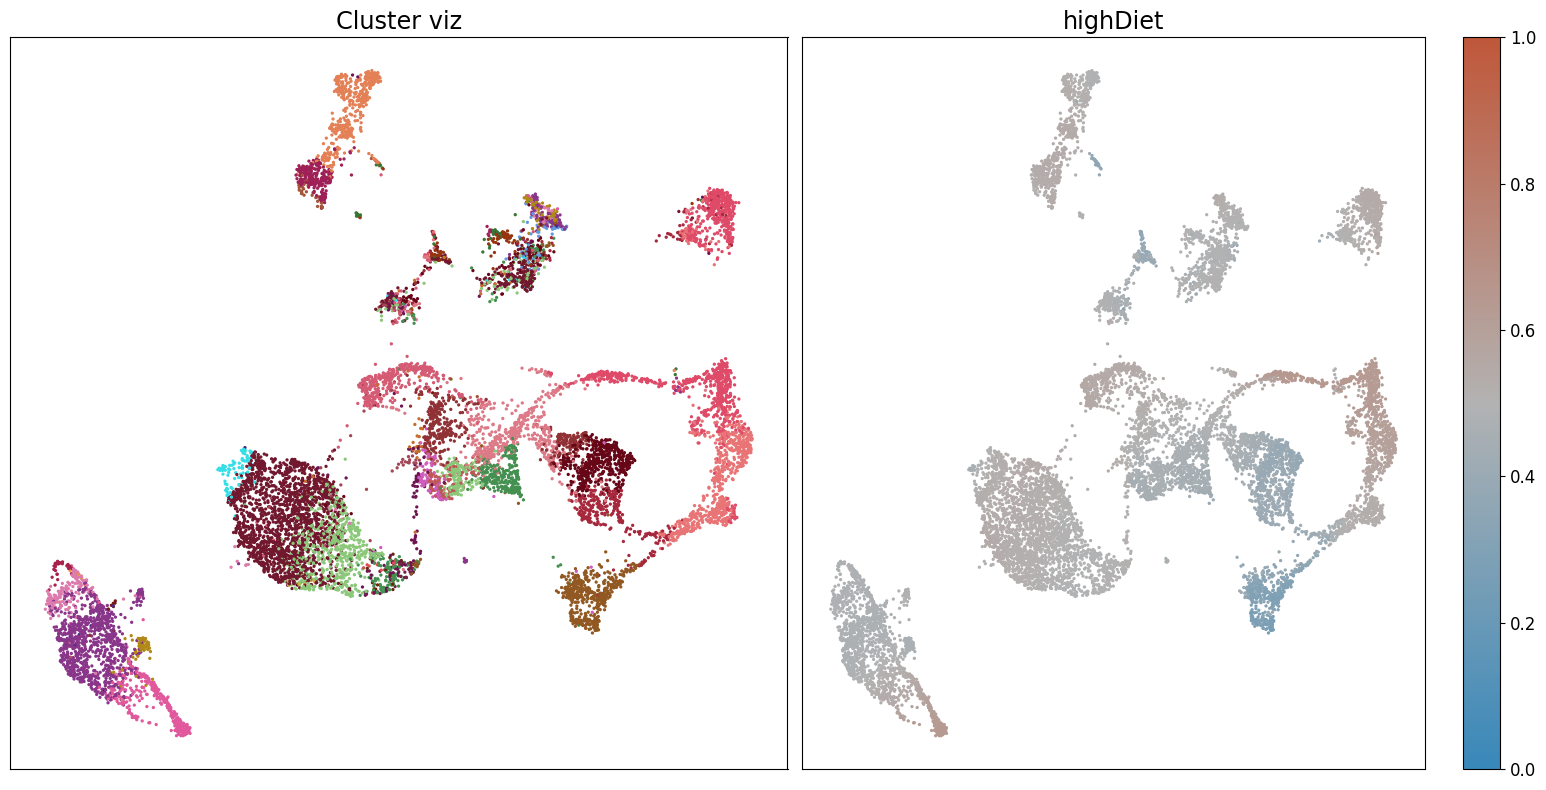

In [62]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

scprep.plot.scatter2d(umap, c=metadata["prediction"], cmap=colors,
                      title='Cluster viz', ticks=False, ax=axes[0], legend=False, legend_anchor=(0,2), legend_loc="upper center") # Legend is finicky, will either try to correctly display or delete the chunk

scprep.plot.scatter2d(umap, c=sample_likelihoods["highDiet"], cmap=meld.get_meld_cmap(),
                        vmin=0, vmax=1,
                        title="highDiet", ticks=False, ax=axes[1])

fig.tight_layout()

In [63]:
#Sort the index of each cluster from lowest to highest average chd likelihood value
metadata["predictionID"] = scprep.utils.sort_clusters_by_values(metadata["prediction"], metadata["cond_likelihood"]) 

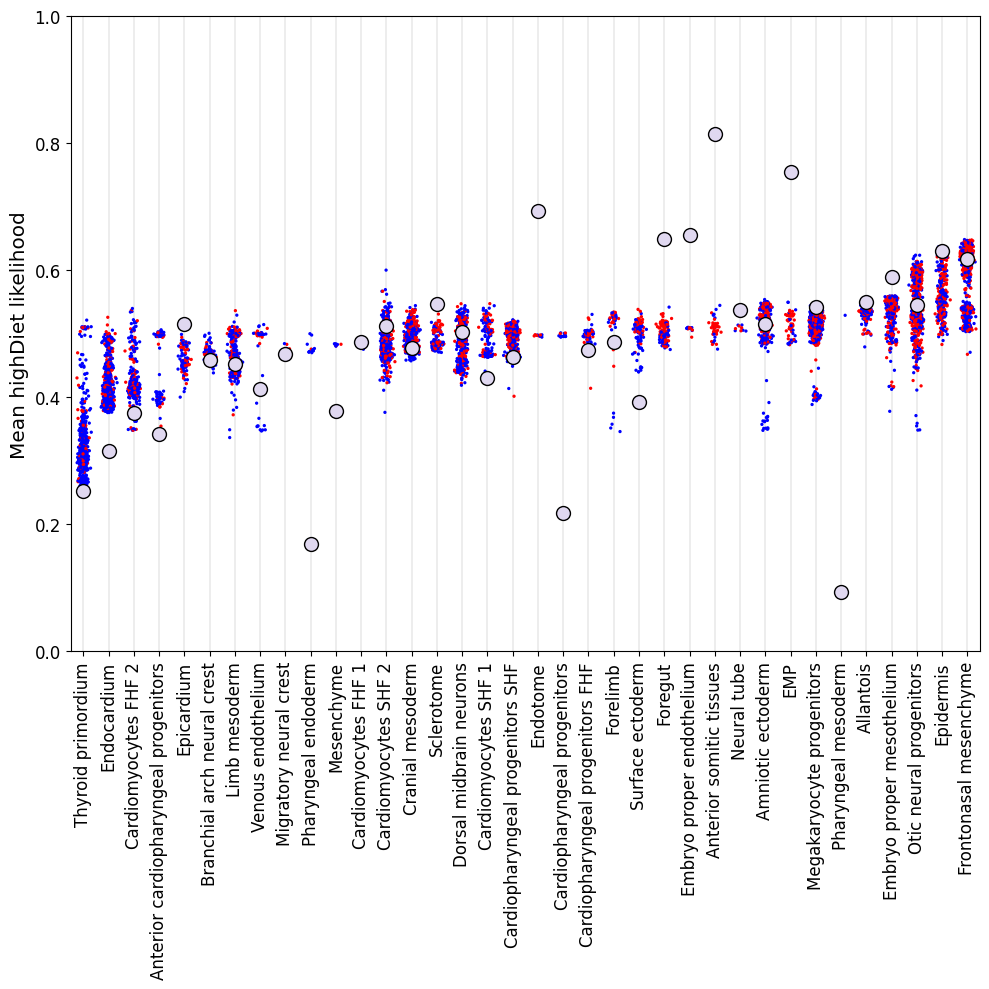

In [64]:
fig, ax = plt.subplots(1, figsize = (10,10))

scprep.plot.jitter(metadata['predictionID'], metadata['cond_likelihood'], c=metadata['orig.ident'], 
                   cmap={1:"red",0:"blue"},legend=False, plot_means=False, xlabel=False, ylabel='Mean highDiet likelihood', # todo: update cmap
                   ax=ax)

### This code will plot the condition ratio of cells per cluster
means = metadata.groupby('predictionID')['orig.ident'].mean()

# If means is negative, it means the likelihood of the cells in this cluster being from the condition's dataset is negative.
# Hence the + 0.5
ax.scatter(means.index, means - np.mean(metadata["orig.ident"]) + 0.5, color='#e0d8f0', edgecolor='k', s=100)

# Axis tick labels
ax.set_xticklabels(metadata['prediction'].drop_duplicates().sort_index(), rotation=90)
ax.set_ylim(0,1)

fig.tight_layout()


In [65]:
clusters, counts = np.unique(metadata['prediction'], return_counts=True)
# Keep cluster labels with at least 1% of the data
clusters = clusters[counts > data.shape[0] * 0.01]

In [67]:
data_cluster_phate = {}

for cluster in clusters:
    curr_data = data.loc[metadata['prediction'] == cluster]
    # Run phate on all clusters. Maybe try to do without it ?
    data_cluster_phate[cluster] = phate.PHATE(verbose=0).fit_transform(curr_data)

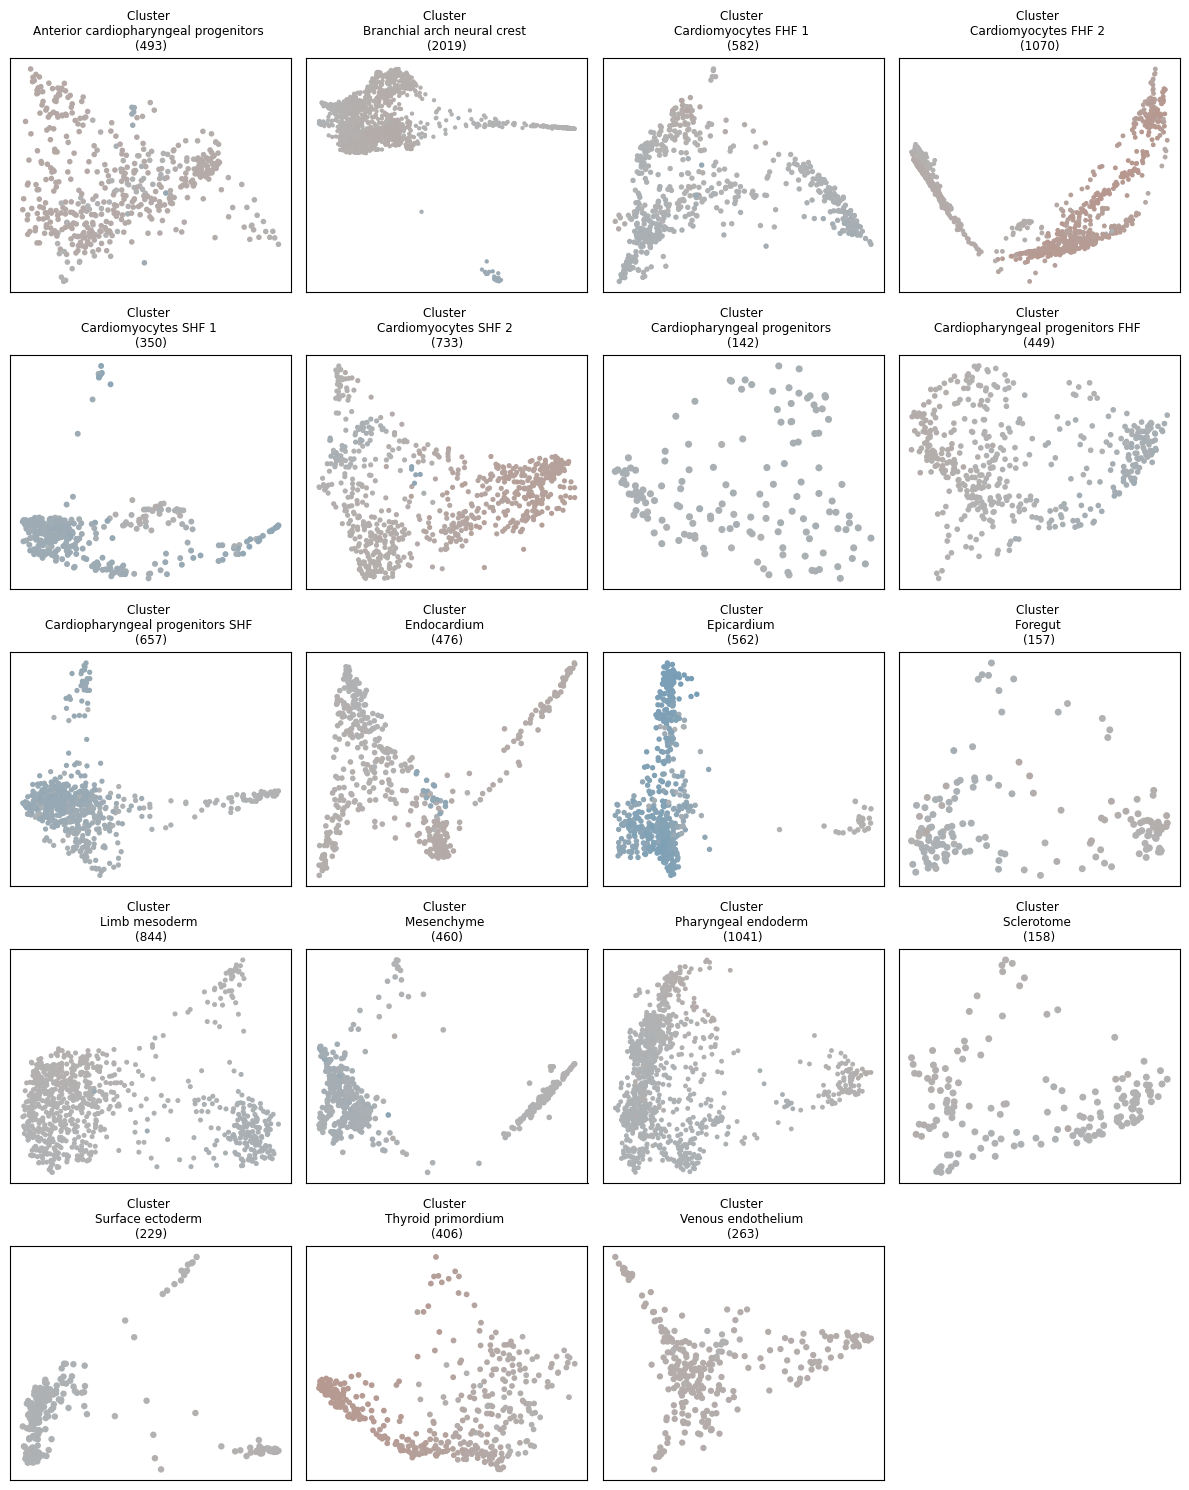

In [71]:
fig,axes= plt.subplots(5,4, figsize=(4*3, 5*3))

for i , ax in enumerate(axes.flatten()):
    if not i < len(clusters):
        ax.axis('off')
        continue
    curr_cluster = clusters[i]
    curr_phate = data_cluster_phate[curr_cluster]
    
    # Plots with different condition likelihood values can probably be subclustered using VFC
    scprep.plot.scatter2d(curr_phate, 
                          c=metadata['cond_likelihood'].loc[metadata['prediction'] == curr_cluster], 
                          cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                         ax=ax, ticks=False, 
                          title='Cluster \n{} \n({})'.format(curr_cluster, curr_phate.shape[0]), 
                          legend=False, fontsize=5)
fig.tight_layout()


Up next : VFC subclustering